In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import os
from src import config

In [2]:
features_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "pairwise_sessions_features_df.pkl"))
labels_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "pairwise_sessions_labels_df.pkl"))

In [3]:
# Remove all the features that are contains 'Post' in their name
features_df = features_df.loc[:, ~features_df.columns.str.contains('Post')]

# Remove all the features that are contains 'SQRT' in their name
features_df = features_df.loc[:, ~features_df.columns.str.contains('SQRT')]

# Remove all the features that are start with 'Distance' in their name
features_df = features_df.loc[:, ~features_df.columns.str.startswith('Distance')]

# Remove all the features and keep only the ones that are contains 'DVA' in their name
# features_df = features_df.loc[:, features_df.columns.str.startswith('DVA')]

# Change the names of the features to be more readable-
# remove the suffix '_Pre'
features_df.columns = [col.replace('_Pre', '') for col in features_df.columns]

# Take all the features that start with 'DVA', and add the suffix '_Distance' to them
features_df.columns = [col + '_Distance' if col.startswith('DVA') else col for col in features_df.columns]
features_df.columns = [col.replace('DVA_', '') for col in features_df.columns]

# Replace '_' with ' ' (space)
features_df.columns = [col.replace('_', ' ') for col in features_df.columns]

features_df.head()

,Movie,Gaze Counts In RoI,Gaze Counts Out RoI,Gaze In out RoI Ratio,Gaze Re Entries To RoI Count,Gaze Re Entries To RoI Rate,Gaze Mean Pupil Change On Event,Fixations Counts In RoI,Fixations Counts Out RoI,Fixations In out RoI Ratio,...,Min Gaze Distance,Sem Gaze Distance,AUC Gaze Distance,Mean Fixations Distance,Median Fixations Distance,Std Fixations Distance,Max Fixations Distance,Min Fixations Distance,Sem Fixations Distance,AUC Fixations Distance
0,19,-0.545455,0.212985,-0.642266,-0.8,-0.8,2.903038,-0.4,0.266667,-0.56,...,0.201053,-0.162551,0.303052,0.343968,0.383264,-0.045712,0.037834,0.781439,-0.100289,0.416861
1,13,1.0,-0.130298,1.0,1.0,1.0,0.316704,1.0,0.111111,1.0,...,-0.522926,0.356101,-0.064838,-0.043316,-0.121632,0.307978,0.030588,-0.494648,0.20719,0.203598
2,32,0.929412,-0.019775,0.930808,-0.75,-0.75,-0.003264,1.0,0.344828,1.0,...,1.0,-0.352422,0.293406,0.245878,0.368718,-0.255102,0.032128,0.114437,-0.407194,0.522389
3,18,NaN,0.0,NaN,NaN,NaN,0.316337,NaN,0.264706,NaN,...,-1.0,0.231838,-0.031344,-0.031364,-0.041235,0.146856,0.005983,0.047307,0.005072,0.240897
4,16,0.6,-0.001181,0.600472,0.0,0.0,-0.587239,NaN,-0.0625,NaN,...,-0.997524,0.038798,0.048274,0.057843,0.072574,-0.006875,0.038747,-0.015875,0.025051,-0.004943


In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 76 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Movie                                     4352 non-null   int8  
 1   Gaze Counts In RoI                        3088 non-null   object
 2   Gaze Counts Out RoI                       4352 non-null   object
 3   Gaze In out RoI Ratio                     3088 non-null   object
 4   Gaze Re Entries To RoI Count              3088 non-null   object
 5   Gaze Re Entries To RoI Rate               3088 non-null   object
 6   Gaze Mean Pupil Change On Event           4332 non-null   object
 7   Fixations Counts In RoI                   2472 non-null   object
 8   Fixations Counts Out RoI                  4342 non-null   object
 9   Fixations In out RoI Ratio                2472 non-null   object
 10  Fixations Re Entries To RoI Count         2472 n

In [5]:
labels_df.head()

,normalized_by_session_a
series_id,
0,1
1,0
2,0
3,0
4,1


In [6]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352 entries, 0 to 4351
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   normalized_by_session_a  4352 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB


Subject-wise or leave-one-subject-out (LOSO) cross-validation

Leave-One-Subject-Out Cross-Validation (LOSO CV):
- For each fold of the cross-validation, data from N-1 participants are used for training, and the data from the remaining participant is used for testing.
- This process is repeated N times (for each participant), ensuring that each participant's data is used as a test set exactly once.
- This method ensures that the model generalizes well across different participants.

In [7]:
series_id_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "pairwise_sessions_series_id_df.pkl"))

# remove the corresponding rows from y_train
series_id_df = series_id_df.loc[series_id_df.index.isin(features_df.index)]

# Create a list of unique subject IDs
subject_ids = series_id_df[config.SUBJECT].unique()

# Order the list of subject IDs alphabetically
subject_ids = np.sort(subject_ids)

# Create groups of subject IDs
groups = series_id_df[config.SUBJECT].values

# Print the groups
print(groups)

['DK47' 'AS20' 'TA01' ... 'KL89' 'BH27' 'HM02']


In [8]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [9]:
# XGBoost model

def xgboost_model_searcher():
    # Define the range of values for each hyperparameter
    LEARNING_RATE = np.linspace(0.001, 0.5, 15)
    MAX_DEPTH = range(2, 5)
    N_ESTIMATORS = range(100, 150, 5)
    
    XGB_PARAM_GRID  = {
        'learning_rate': LEARNING_RATE,
        'max_depth': MAX_DEPTH,
        'n_estimators': N_ESTIMATORS
    }
    
    return GridSearchCV(estimator=XGBClassifier(), param_grid=XGB_PARAM_GRID, verbose=0)

In [10]:
classifiers = {
    'XGBoost': xgboost_model_searcher()
}

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model_name, y_test, y_pred):
    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(model_name)
    # Print the evaluation metrics
    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1-score:", round(f1, 2))
    print("ROC-AUC score:", round(roc_auc, 2))

    # Compute the confusion matrix in average format (i.e., divide by the number of samples with the corresponding label)
    confusion_mat = confusion_matrix(y_test, y_pred, normalize='true') * 100
    # round the values in the confusion matrix
    confusion_mat = np.round(confusion_mat).astype(int)
    
    # Create a heatmap visualization of the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", ax=ax)

    # Set the axis labels and title
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")

    # Show the plot
    plt.show()
    
    return confusion_mat

XGBoost on AI09
Accuracy: 0.56
Precision: 0.56
Recall: 0.56
F1-score: 0.56
ROC-AUC score: 0.56


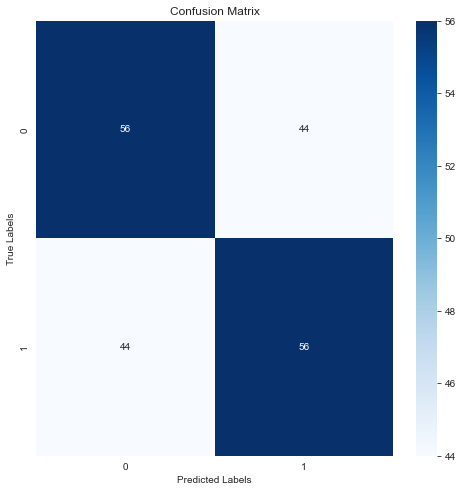

XGBoost on AJ31
Accuracy: 0.68
Precision: 0.68
Recall: 0.69
F1-score: 0.68
ROC-AUC score: 0.68


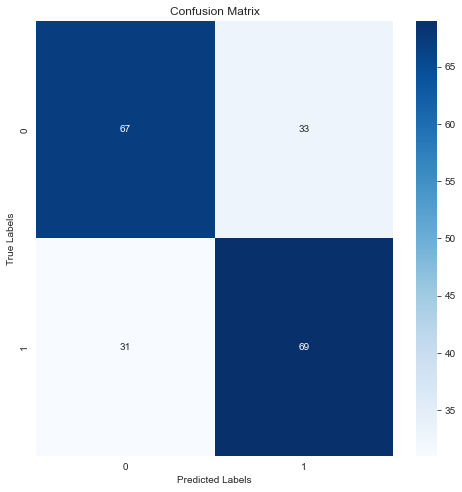

XGBoost on AM45
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1-score: 0.86
ROC-AUC score: 0.86


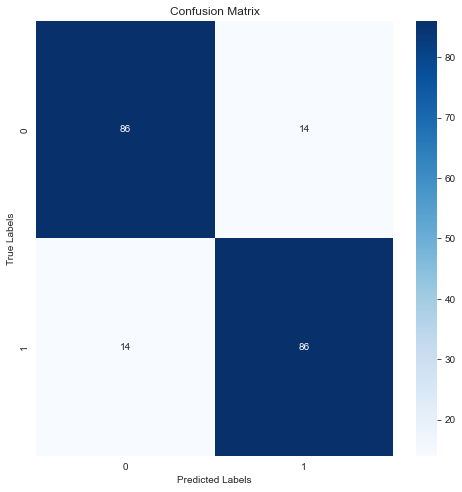

XGBoost on AS20
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1-score: 0.86
ROC-AUC score: 0.86


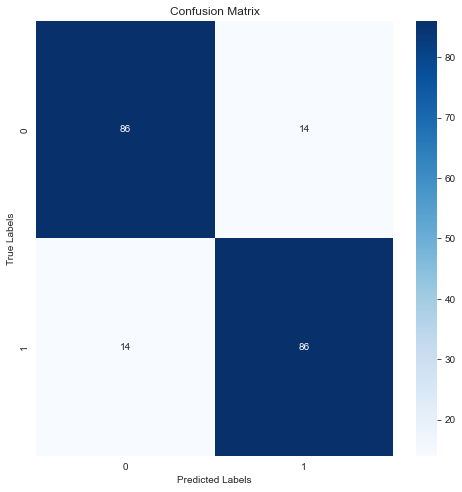

XGBoost on BB30
Accuracy: 0.51
Precision: 0.51
Recall: 0.52
F1-score: 0.51
ROC-AUC score: 0.51


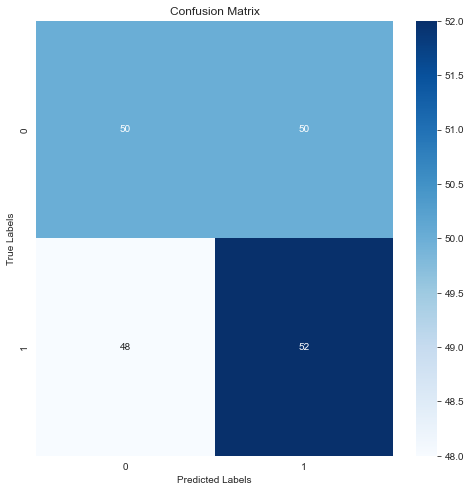

XGBoost on BG97
Accuracy: 0.49
Precision: 0.49
Recall: 0.47
F1-score: 0.48
ROC-AUC score: 0.49


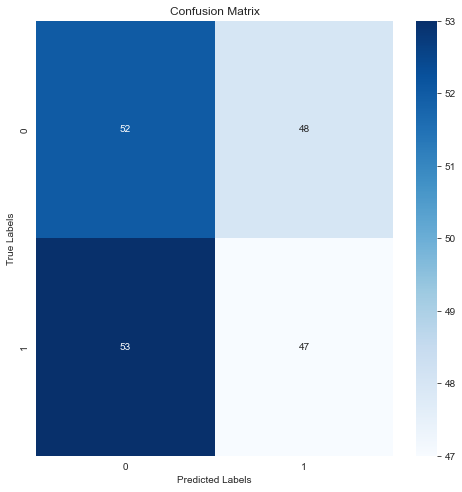

XGBoost on BH27
Accuracy: 0.55
Precision: 0.55
Recall: 0.52
F1-score: 0.53
ROC-AUC score: 0.55


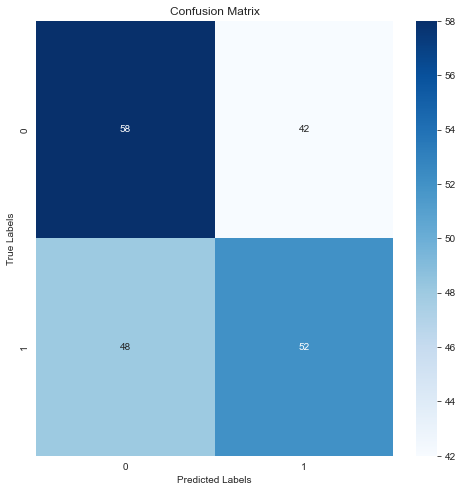

XGBoost on BO03
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1-score: 0.83
ROC-AUC score: 0.83


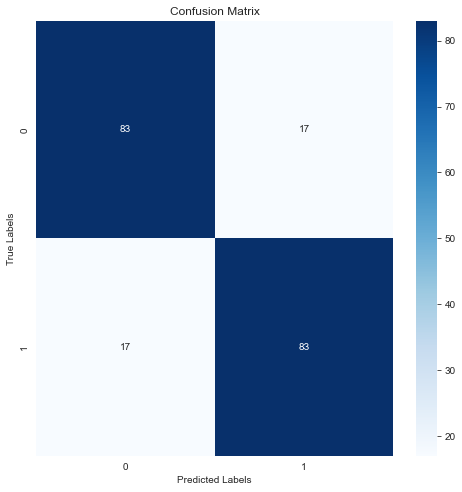

XGBoost on CR06
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1-score: 0.77
ROC-AUC score: 0.77


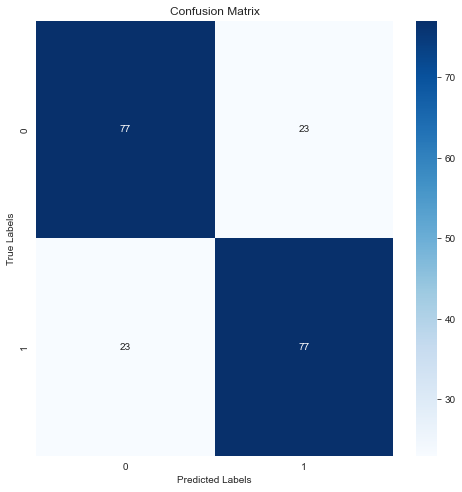

XGBoost on DK47
Accuracy: 0.7
Precision: 0.7
Recall: 0.7
F1-score: 0.7
ROC-AUC score: 0.7


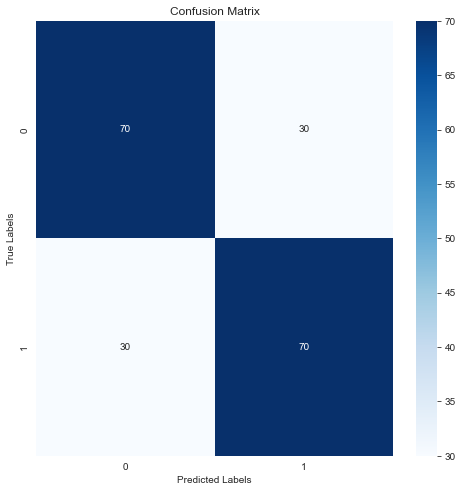

XGBoost on FY25
Accuracy: 0.68
Precision: 0.68
Recall: 0.67
F1-score: 0.68
ROC-AUC score: 0.68


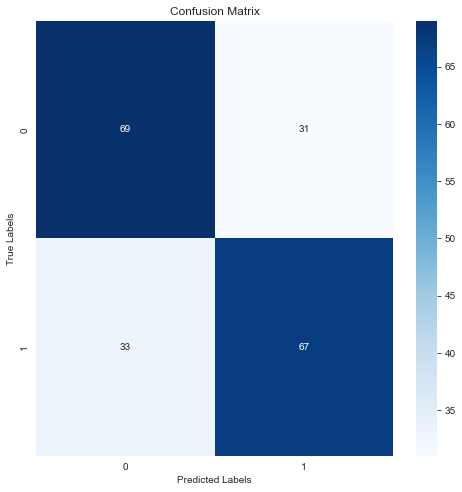

XGBoost on GE44
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1-score: 0.75
ROC-AUC score: 0.75


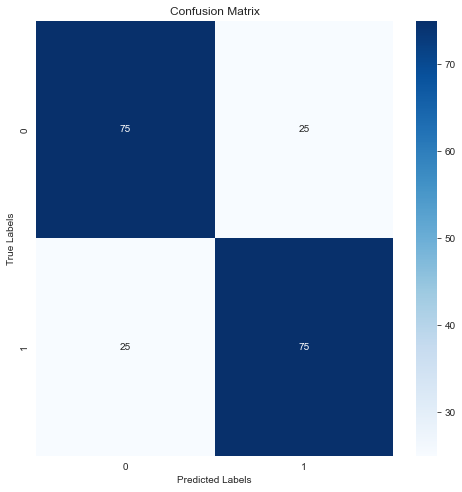

XGBoost on GN10
Accuracy: 0.69
Precision: 0.69
Recall: 0.67
F1-score: 0.68
ROC-AUC score: 0.69


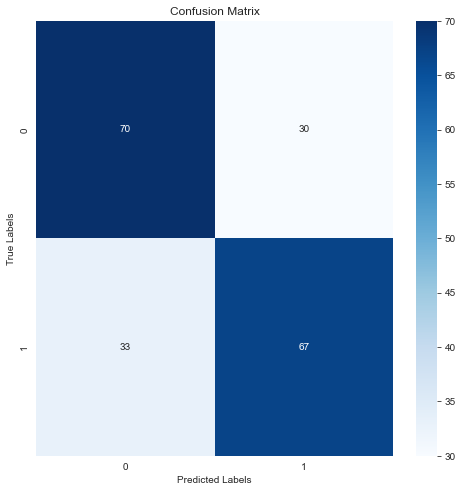

XGBoost on HB81
Accuracy: 0.74
Precision: 0.75
Recall: 0.73
F1-score: 0.74
ROC-AUC score: 0.74


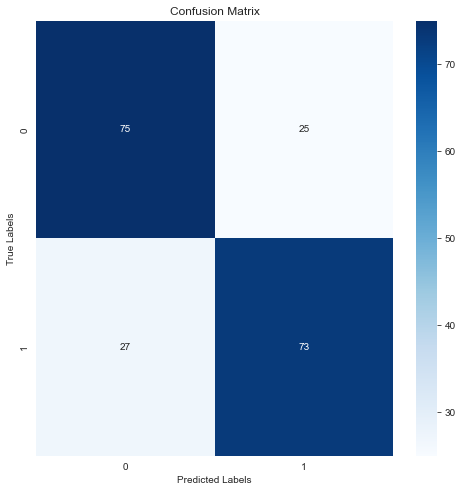

XGBoost on HM02
Accuracy: 0.72
Precision: 0.73
Recall: 0.7
F1-score: 0.71
ROC-AUC score: 0.72


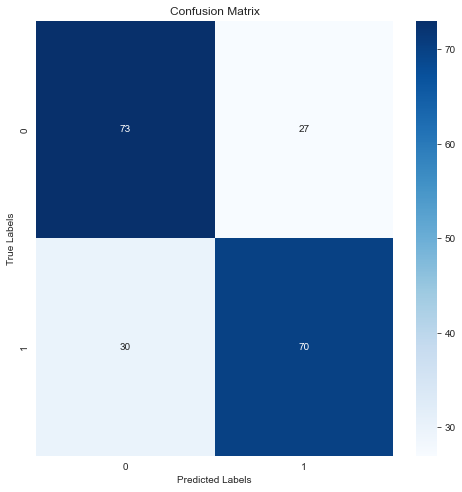

XGBoost on HR58
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-score: 0.89
ROC-AUC score: 0.89


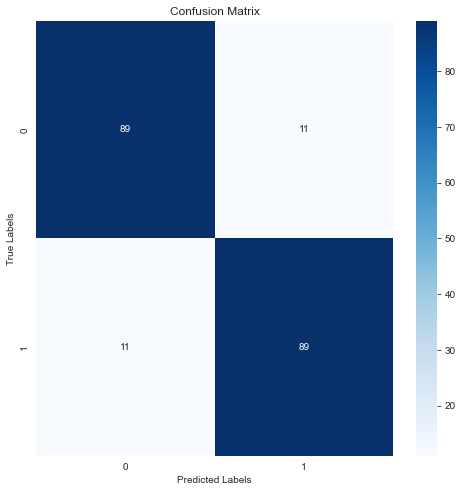

XGBoost on KL89
Accuracy: 0.62
Precision: 0.62
Recall: 0.62
F1-score: 0.62
ROC-AUC score: 0.62


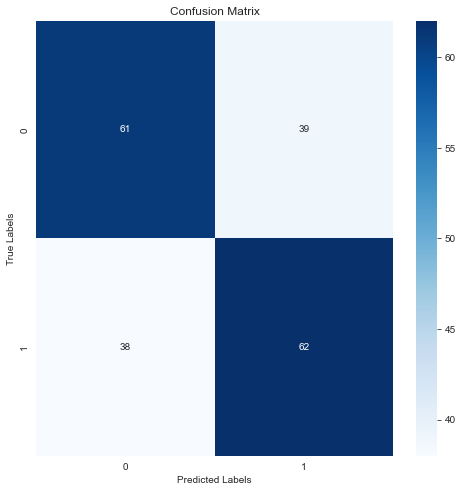

XGBoost on KM28
Accuracy: 0.62
Precision: 0.62
Recall: 0.62
F1-score: 0.62
ROC-AUC score: 0.62


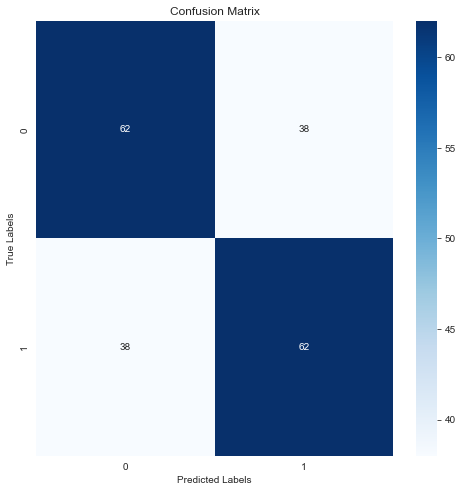

XGBoost on KR13
Accuracy: 0.77
Precision: 0.79
Recall: 0.75
F1-score: 0.77
ROC-AUC score: 0.77


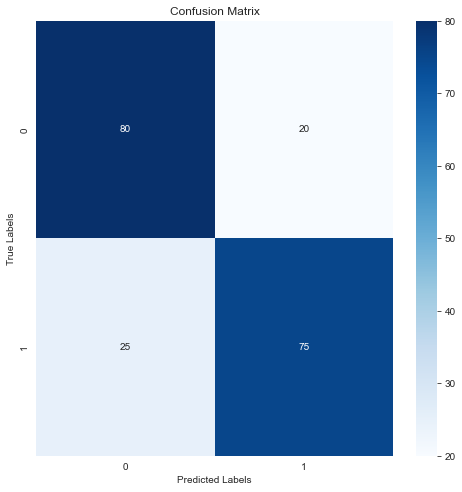

XGBoost on MA40
Accuracy: 0.65
Precision: 0.65
Recall: 0.64
F1-score: 0.65
ROC-AUC score: 0.65


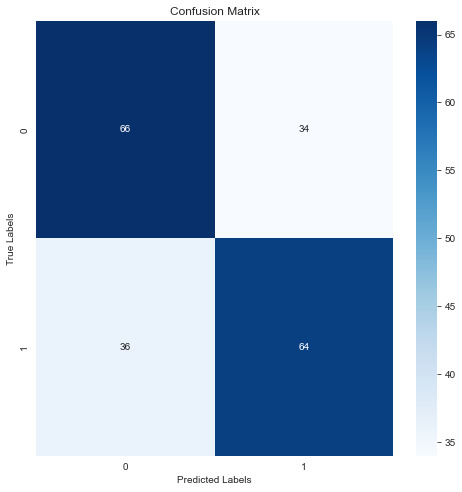

XGBoost on MN01
Accuracy: 0.66
Precision: 0.66
Recall: 0.67
F1-score: 0.67
ROC-AUC score: 0.66


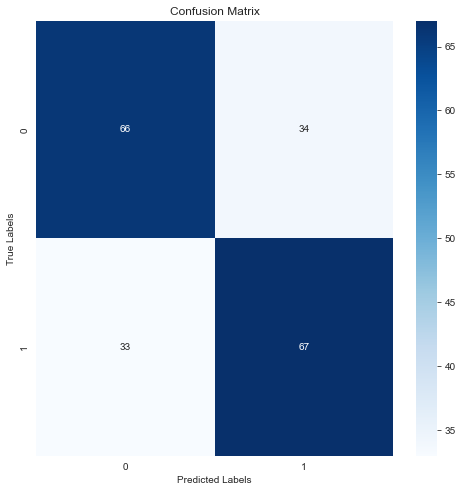

XGBoost on MN37
Accuracy: 0.62
Precision: 0.62
Recall: 0.64
F1-score: 0.63
ROC-AUC score: 0.62


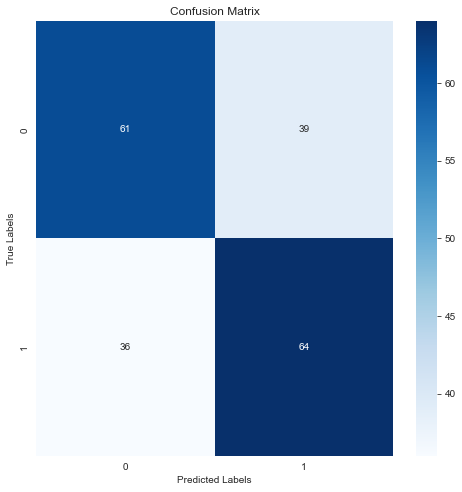

XGBoost on NN81
Accuracy: 0.87
Precision: 0.86
Recall: 0.88
F1-score: 0.87
ROC-AUC score: 0.87


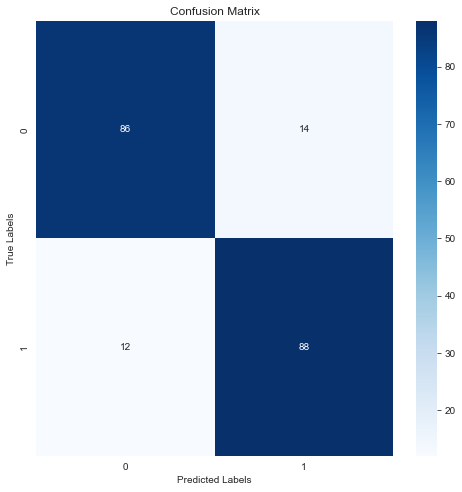

XGBoost on NY90
Accuracy: 0.77
Precision: 0.78
Recall: 0.77
F1-score: 0.77
ROC-AUC score: 0.77


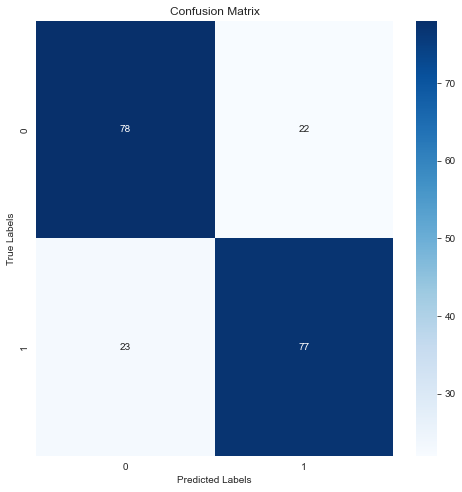

XGBoost on PM15
Accuracy: 0.9
Precision: 0.89
Recall: 0.91
F1-score: 0.9
ROC-AUC score: 0.9


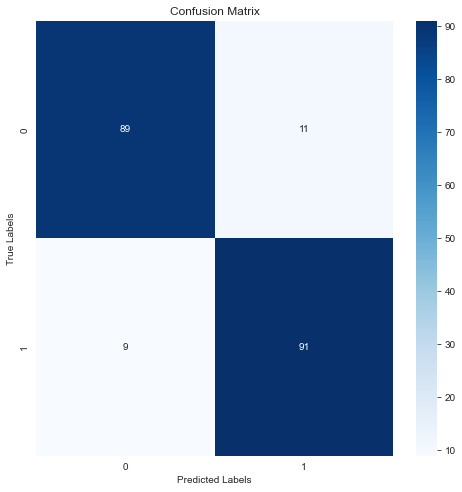

XGBoost on PS08
Accuracy: 0.55
Precision: 0.55
Recall: 0.55
F1-score: 0.55
ROC-AUC score: 0.55


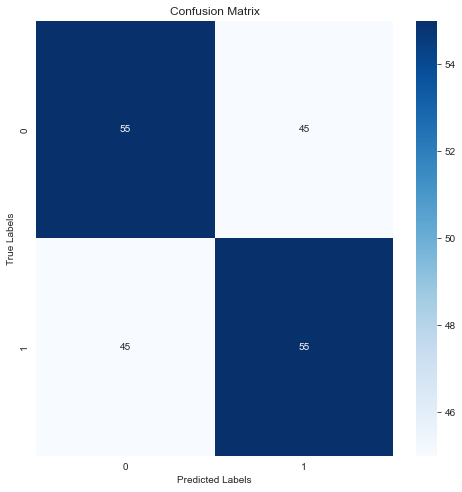

XGBoost on RN85
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-score: 0.91
ROC-AUC score: 0.91


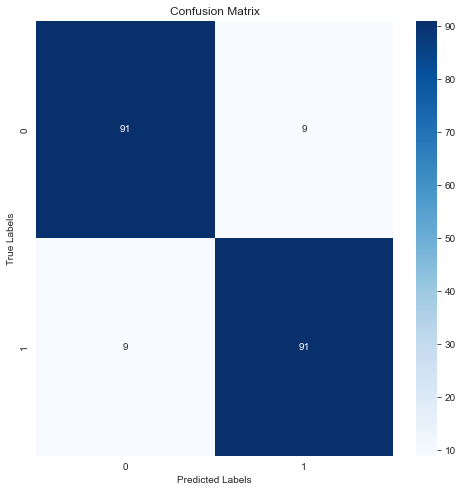

XGBoost on RS30
Accuracy: 0.63
Precision: 0.63
Recall: 0.62
F1-score: 0.63
ROC-AUC score: 0.63


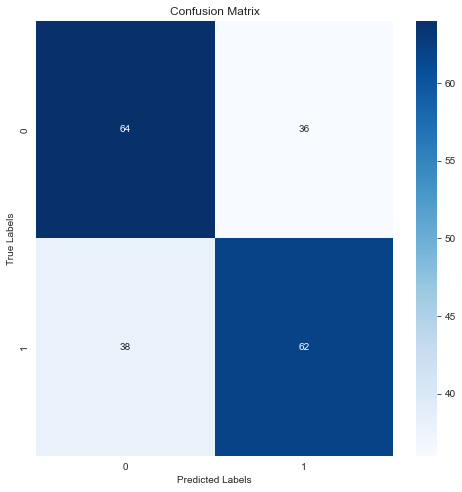

XGBoost on RY20
Accuracy: 0.56
Precision: 0.56
Recall: 0.55
F1-score: 0.56
ROC-AUC score: 0.56


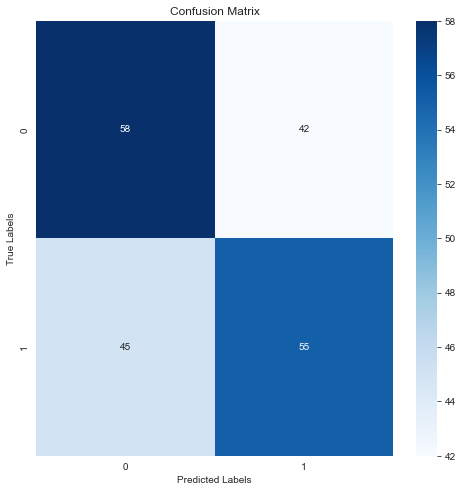

XGBoost on SM28
Accuracy: 0.5
Precision: 0.5
Recall: 0.48
F1-score: 0.49
ROC-AUC score: 0.5


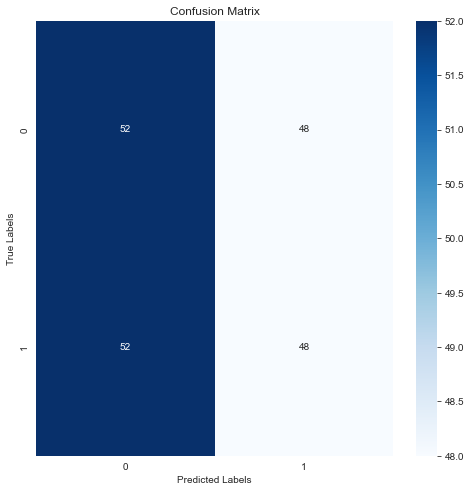

XGBoost on TA01
Accuracy: 0.61
Precision: 0.61
Recall: 0.61
F1-score: 0.61
ROC-AUC score: 0.61


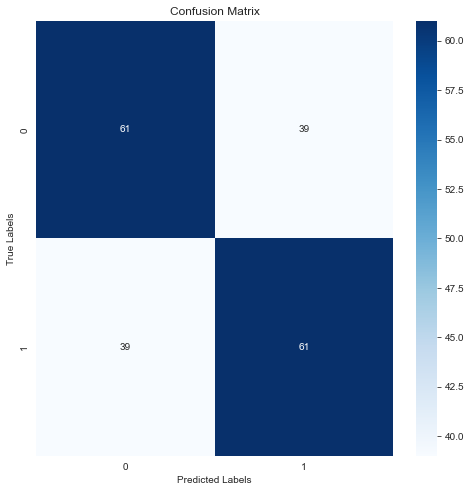

XGBoost on WE10
Accuracy: 0.77
Precision: 0.79
Recall: 0.75
F1-score: 0.77
ROC-AUC score: 0.77


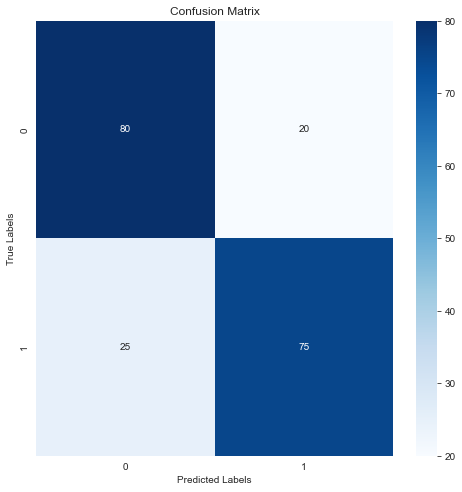

XGBoost on ZN05
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1-score: 0.75
ROC-AUC score: 0.75


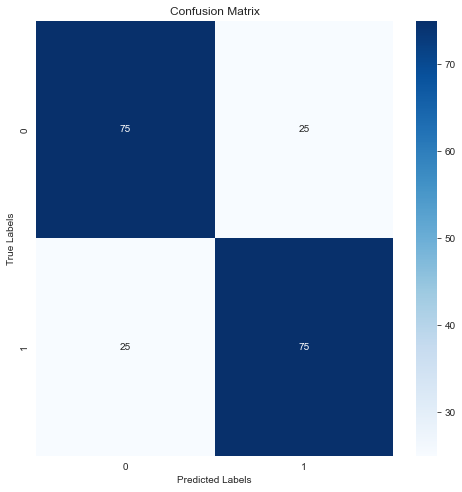

XGBoost on ZW57
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1-score: 0.77
ROC-AUC score: 0.77


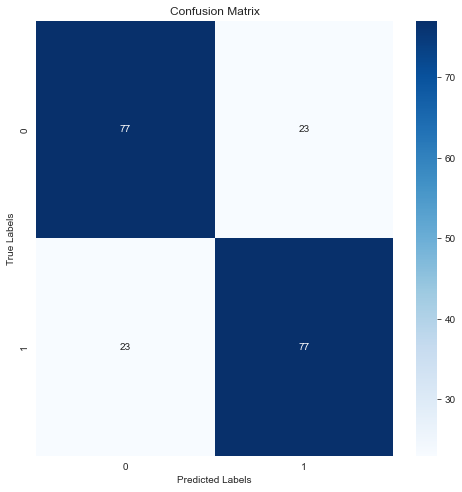

Average accuracy of XGBoost: 0.7004
Average confusion matrix of XGBoost: [[70.52941176 29.47058824]
 [30.35294118 69.64705882]]

The best classifier is: XGBoost with accuracy: 0.7004


In [12]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
from sklearn.impute import KNNImputer
import sys

# Initialize LeaveOneSubjectOut cross-validator
logo = LeaveOneGroupOut()

# Function to perform LOSO CV and return average accuracy
def evaluate_classifier(model_searcher, X, y, groups, name):
    accuracies = {}
    confusion_matricies = {}
    confidence_intervals = {}
    models = {}
    roc_auc_curves = {}
    shap_values_dict = {}

    for train_index, test_index in logo.split(X, y, groups):
        # Extract indices for training and testing data for each participant
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fill inf values with the maximum int, and -inf with the minimum int
        X_train = X_train.replace(np.inf, sys.maxsize)
        X_train = X_train.replace(-np.inf, -sys.maxsize)
        X_test = X_test.replace(np.inf, sys.maxsize)
        X_test = X_test.replace(-np.inf, -sys.maxsize)

        # Create the imputer
        imputer = KNNImputer(n_neighbors=7)
        # Apply the imputer to the DataFrame
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # Scale the data
        # Create separate StandardScaler instances
        # scaler_x = StandardScaler()
        # # Fit on Training Data (!)
        # scaler_x.fit(X_train)
        # # Transform both training and testing data
        # X_train_scaled = scaler_x.transform(X_train)
        # X_test_scaled = scaler_x.transform(X_test)
        # y_train = y_train.values.reshape(-1, 1).flatten()
        # y_test = y_test.values.reshape(-1, 1).flatten()
        # X_train_scaled = X_train_scaled
        # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        X_test_scaled = X_test
        X_train_scaled = X_train

        model_searcher.fit(X_train_scaled, y_train)
        clf = model_searcher.best_estimator_

        # Fit the classifier
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        # Store the results for this fold using subject name as key
        subject_name = groups[test_index[0]]
        accuracies[subject_name] = acc
        conf_mat = evaluate_model(f"{name} on {subject_name}", y_test, y_pred)
        confusion_matricies[subject_name] = conf_mat
        models[subject_name] = clf
        confidence_intervals[subject_name] = (acc - 1.96 * np.sqrt(acc * (1 - acc) / len(y_test)), acc + 1.96 * np.sqrt(acc * (1 - acc) / len(y_test)))
        roc_auc_curves[subject_name] = y_test, clf.predict_proba(X_test_scaled)[:, 1]

        # Calculate Shap values
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test_scaled)
        shap_values_dict[subject_name] = shap_values
        
    # return all the computed dictionaries
    return accuracies, confusion_matricies, confidence_intervals, models, roc_auc_curves, shap_values_dict

# Evaluate each classifier
results = {}
for name, clf in classifiers.items():
    acc, confusion_matricies, confidence_intervals, models, roc_auc_curves, shap_values_dict = evaluate_classifier(clf, features_df, labels_df, groups, name)
    avg_confusion_matrix = np.mean(list(confusion_matricies.values()), axis=0)
    avg_acc = np.mean(list(acc.values())) 
    sd_acc = np.std(list(acc.values()))

    results[name] = avg_acc, avg_confusion_matrix, acc, confusion_matricies, confidence_intervals, models, roc_auc_curves, shap_values_dict, sd_acc
    print(f"Average accuracy of {name}: {avg_acc:.4f}")
    print(f"Average confusion matrix of {name}: {avg_confusion_matrix}")

# Decision-making (choose the classifier with the highest average accuracy)
best_classifier_name = max(results, key=lambda k: results[k][0])
print(f"\nThe best classifier is: {best_classifier_name} with accuracy: {results[best_classifier_name][0]:.4f}")

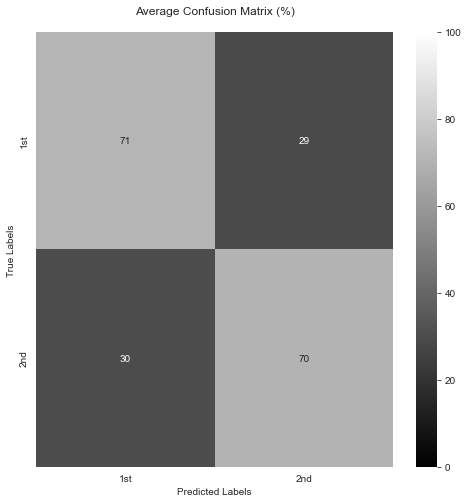

Average correct classification rate for 1st viewing: 71.00% ± 11.73%
Average correct classification rate for 2nd viewing: 70.00% ± 12.34%


In [13]:
# Plot the average confusion matrix
# round the values in the confusion matrix
avg_confusion_matrix_round = np.round(results[best_classifier_name][1]).astype(int)

# Create a heatmap visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
# the color range should start at 0 and end at the maximum value in the confusion matrix
sns.heatmap(avg_confusion_matrix_round, annot=True, cmap="gray", fmt="d", ax=ax, vmin=0, vmax=100)

# Set the axis values- replace 0 with 1st viewing and 1 with 2nd viewing
ax.set_xticklabels(['1st', '2nd'])
ax.set_yticklabels(['1st', '2nd'])


# Set the axis labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Average Confusion Matrix (%)\n")

# Style
# Make the fonts visible in the plot
plt.rcParams.update({'font.size': 30})
# Make the tick labels of the heatmap visible
for tick in ax.get_xticklabels():
    tick.set_visible(True)
for tick in ax.get_yticklabels():
    tick.set_visible(True)
    
# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "confusion_matrix.svg"), bbox_inches='tight')

# Show the plot
plt.show()

# Print the average correct classification rate for each class and the standard deviation
print(f"Average correct classification rate for 1st viewing: {avg_confusion_matrix_round[0, 0]:.2f}% ± {np.std([conf_mat[0, 0] for conf_mat in results[best_classifier_name][3].values()]):.2f}%")
print(f"Average correct classification rate for 2nd viewing: {avg_confusion_matrix_round[1, 1]:.2f}% ± {np.std([conf_mat[1, 1] for conf_mat in results[best_classifier_name][3].values()]):.2f}%")  

Calculating ROC AUC for each participant (fold)

[0.3186087  0.7115992  0.6841565  ... 0.6259145  0.3356591  0.22197689]


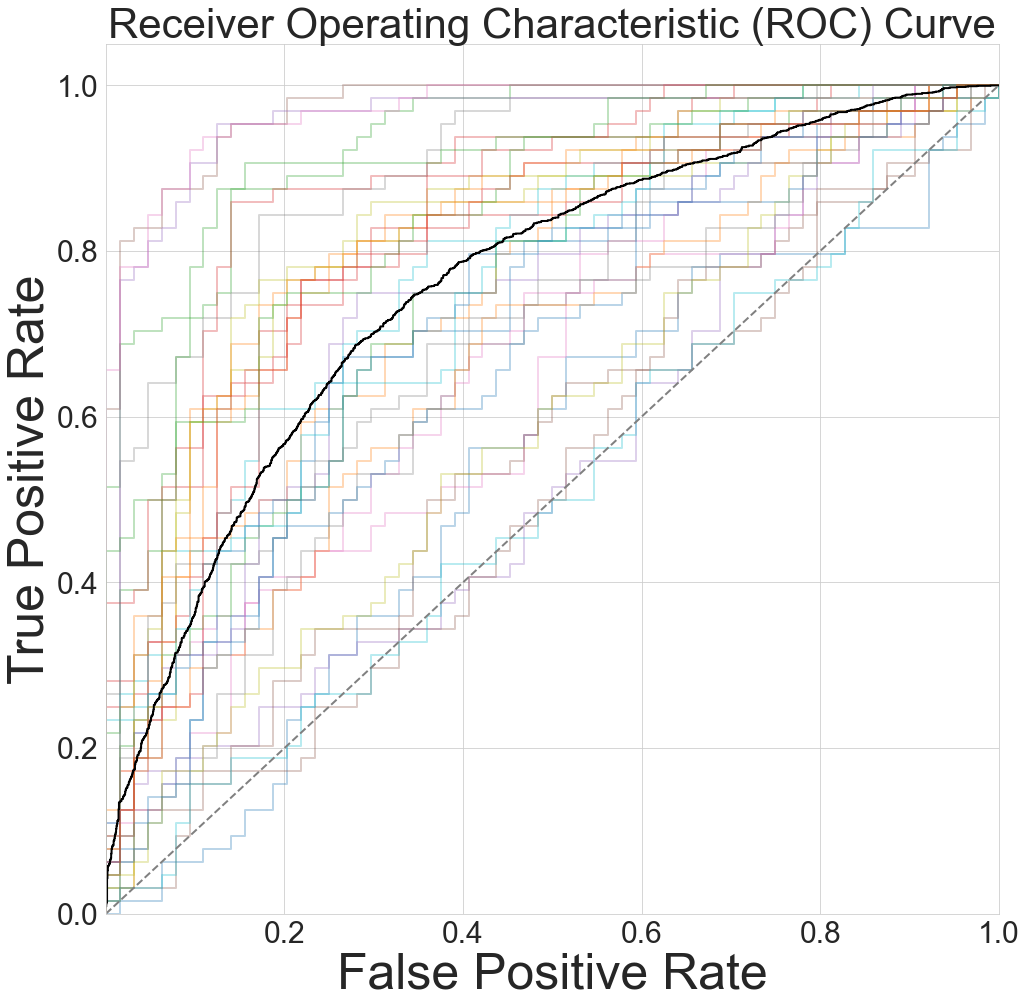

Average ROC AUC: 0.7582 ± 0.2658


In [14]:
from sklearn.metrics import roc_curve, auc

roc_auc_curves = results[best_classifier_name][6]

# Plot ROC curve for each participant
fig, ax = plt.subplots(figsize=(16, 16))

# For each fold calculate ROC curve and ROC area
for subject_name, (y_test, y_pred) in roc_auc_curves.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve with transparency
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC curve of {subject_name} (area = {roc_auc:.2f})')
    

y_test, y_pred = np.concatenate([y_test for y_test, y_pred in roc_auc_curves.values()]), np.concatenate([y_pred for y_test, y_pred in roc_auc_curves.values()])
# Plot ROC curve for average classifier with error bars representing 95% confidence intervals
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(y_pred)
# ROC AUC average Standard Deviation
sd_auc = np.std(tpr)
 
ax.plot(fpr, tpr, color='black', lw=2, label=f'ROC curve of average classifier (area = {roc_auc:.2f})')

# Plot ROC curve for random classifier
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

# Set the limits of the plot to include both curves, don't show 0.0 twice on the x-axis and the y-axis
ax.set_xlim([0.000001, 1.0])
ax.set_ylim([0.0, 1.05])

# Increase font size
plt.rcParams.update({'font.size': 35})

# Set the axis labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
# Increse xlabel and ylabel font size
ax.xaxis.label.set_size(50)
ax.yaxis.label.set_size(50)

# Transparent background
ax.patch.set_alpha(0.0)

# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "roc_auc.svg"), bbox_inches='tight')

# Show the plot
plt.show()

# Print the average ROC AUC with standard deviation
print(f"Average ROC AUC: {roc_auc:.4f} ± {sd_auc:.4f}")


In [15]:
from scipy.stats import ttest_1samp
from sklearn.metrics import roc_auc_score

roc_auc_curves = results[best_classifier_name][6]
roc_auc_scores = [roc_auc_score(y_test, y_pred) for y_test, y_pred in roc_auc_curves.values()]

# Print the average ROC AUC with standard deviation
print(f" ROC AUC Scores: {roc_auc_scores}, len: {len(roc_auc_scores)}")
      
# Perform 1-sample t-test
t_stat, p_value = ttest_1samp(roc_auc_scores, 0.5)

# Print the results
print(f"1-sample t-test: t({len(roc_auc_scores) - 1}) = {t_stat:.4f}, p = {p_value}")

 ROC AUC Scores: [0.53466796875, 0.7431640625, 0.936767578125, 0.86865234375, 0.542236328125, 0.540771484375, 0.65966796875, 0.901611328125, 0.80419921875, 0.787841796875, 0.71826171875, 0.818603515625, 0.741943359375, 0.810302734375, 0.72412109375, 0.97314453125, 0.6484375, 0.64697265625, 0.83447265625, 0.751220703125, 0.71826171875, 0.669677734375, 0.896240234375, 0.85400390625, 0.953125, 0.5283203125, 0.970703125, 0.72216796875, 0.588134765625, 0.5048828125, 0.658935546875, 0.812744140625, 0.85498046875, 0.79443359375], len: 34
1-sample t-test: t(33) = 10.8570, p = 1.985649694565042e-12


Calculating Performance Across Participants (Subject-wise)

The Y-axis can represent the accuracy for each participant, i.e., the percentage of correct classifications. This is the most direct measure of classifier performance and would be readily interpretable by most readers. We can use error bars to represent confidence intervals for each participant's accuracy.

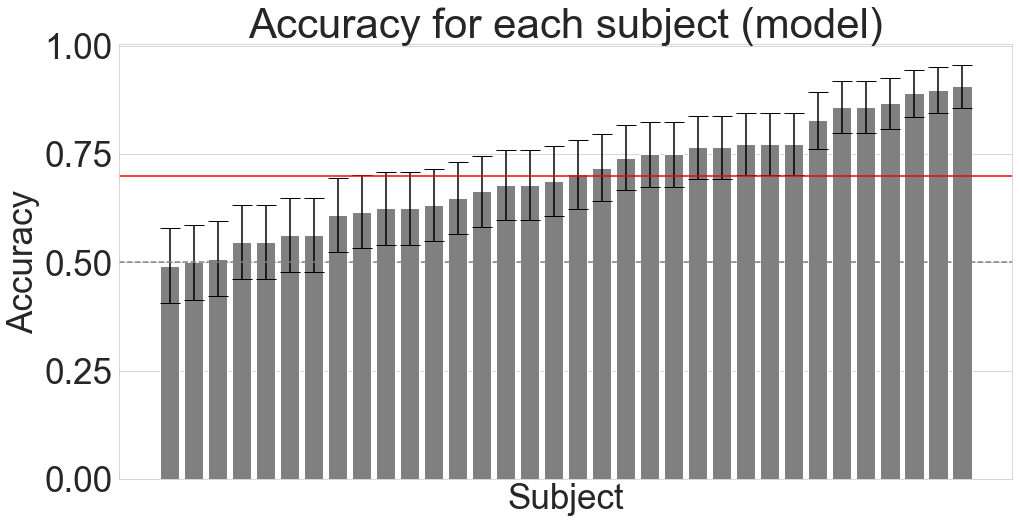

Participants with accuracy above chance level: 32/34
Average accuracy: 0.7004 ± 0.1196


In [16]:
acc = results[best_classifier_name][2]
confidence_intervals = results[best_classifier_name][4]
avg_acc = results[best_classifier_name][0]

# Plot the accuracy for each participant with wide error bars representing 95% confidence intervals for each participant
fig, ax = plt.subplots(figsize=(16, 8))
# Sort the accuracies dictionary by value (accuracy) and plot the values
# Color the bars according to the confidence intervals in grays
ax.bar(sorted(acc, key=acc.get), [acc[key] for key in sorted(acc, key=acc.get)], color='gray', yerr=[[acc[key] - confidence_intervals[key][0] for key in sorted(acc, key=acc.get)], [confidence_intervals[key][1] - acc[key] for key in sorted(acc, key=acc.get)]], capsize=10)
ax.set_xlabel("Subject")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy for each subject (model)")
# remove the ticks from the x-axis
ax.set_xticks([])

# Add a horizontal dashed line representing the average accuracy across participants
ax.axhline(y=avg_acc, color='r', linestyle='-')
# Add horizontal lines representing the chance level accuracy (50%) and the perfect accuracy (100%)
ax.axhline(y=0.5, color='gray', linestyle='--', label='Chance level')
# Add label for the chance level accuracy
# ax.text(0, 0.5, 'Chance level', ha='left', va='center', transform=ax.get_yaxis_transform(), color='gray', alpha=0.5, fontsize=30)

# Increase font size
plt.rcParams.update({'font.size': 40})
# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "accuracy_distribution.svg"), bbox_inches='tight')
# Show the plot
plt.show()

# Print how many participants have accuracy above the chance level
above_chance = sum(acc > 0.5 for acc in acc.values())
print(f"Participants with accuracy above chance level: {above_chance}/{len(acc)}")

# Print the average accuracy with standard deviation
print(f"Average accuracy: {avg_acc:.4f} ± {results[best_classifier_name][8]:.4f}")

Take the best model and train it on the whole dataset

The best model is SVM, so we will train it on the whole dataset, using the average hyperparameters from the LOSO CV

In [17]:
# Get the best model
best_model = results[best_classifier_name][5]

# Go over all the models and average the hyperparameters
best_model_params = {}
for model in best_model.values():
    for param, value in model.get_params().items():
        # If parameter is numeric, add it to the dictionary
        if isinstance(value, (int, float)):
            # if the parameter is already in the dictionary, append the value to the list
            if param in best_model_params:
                best_model_params[param].append(value)
            else:
                best_model_params[param] = [value]
for param, value in best_model_params.items():
    best_model_params[param] = np.mean(value)

best_model_params

{'enable_categorical': 0.0,
 'learning_rate': 0.04817436974789917,
 'max_depth': 3.4705882352941178,
 'missing': nan,
 'n_estimators': 118.67647058823529}

In [18]:
# Train the best model on the whole dataset using the average hyperparameters
X_train = features_df
y_train = labels_df

# fill inf values with the mean of the column
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.mean()) # fill missing values with the mean of the column or zero ? features_df.mean()

# Scale the data
# Create separate StandardScaler instances
scaler_x = StandardScaler()
# Fit on Training Data (!)
scaler_x.fit(X_train.values)
# Transform both training and testing data
X_train_scaled = scaler_x.transform(X_train.values)
y_train = y_train.values.reshape(-1, 1).flatten()
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SVM
# Train final model with best hyperparameters
xgb = XGBClassifier(learning_rate=0.1426, max_depth=2, n_estimators=124)
xgb.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = xgb.predict_proba(X_train_scaled)[:, 1]
# acc = accuracy_score(y_train, y_pred)  
# conf_mat = evaluate_model(f"xgb on whole dataset", y_train, y_pred)


Plot ROC curve

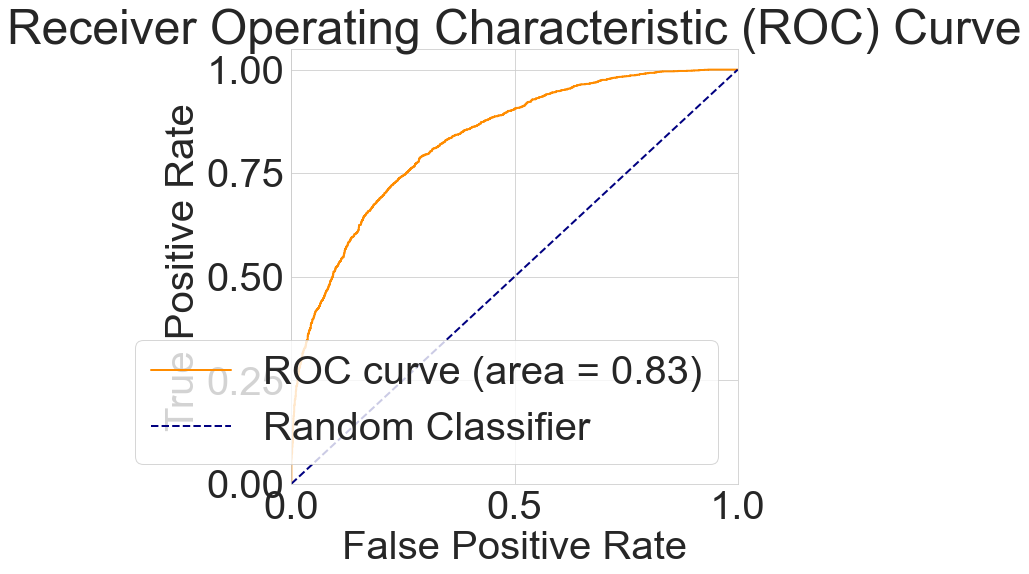

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
 
# Plot ROC curve for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Set the limits of the plot to include both curves
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()

<AxesSubplot:>

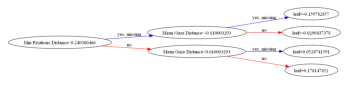

In [20]:
from xgboost import plot_tree

# plot single tree from the model Use visible format
plot_tree(xgb, num_trees=0, rankdir='LR')


Feature importance and SHAP values for the best model

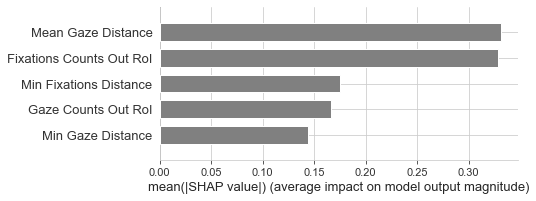

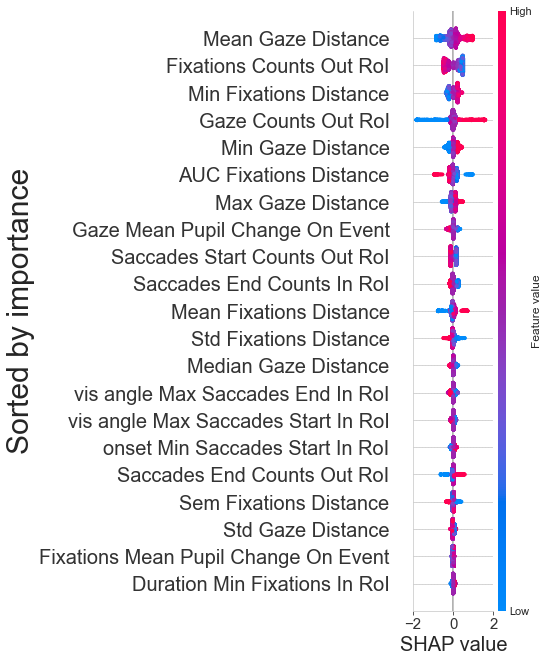

In [21]:
import shap
import matplotlib.pyplot as plt

%matplotlib inline

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb)

# Calculate Shap values
shap_values = explainer.shap_values(X_train_scaled)

# Increase font size
plt.rcParams.update({'font.size': 30})

# Plot summary plot (feature importance) with the top 15 features in gray color
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar", max_display=5, color='gray')

# mark the features that has the suffix '_Distance' in their name with astrisk
# X_train_scaled.columns = ['* ' + col if col.endswith('Distance') else col for col in X_train_scaled.columns]


# Plot summary plot with the top 21 features
shap.summary_plot(shap_values, X_train_scaled, max_display=21, color='gray', show=False)
# Increase font size of the feature names
plt.yticks(fontsize=20)
plt.xticks(fontsize=15)
# Add the y-axis that highlights that the features are sorted by their importance
plt.ylabel("Sorted by importance", fontsize=30)
# centered the y-axis label 

plt.xlabel("SHAP value", fontsize=20)
# add x-axis values
plt.xlim(-2, 2)
plt.tight_layout()
plt.savefig(os.path.join(config.classification_resource_dir, "shap_values_summary.svg"))




# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "shap_values.png"))

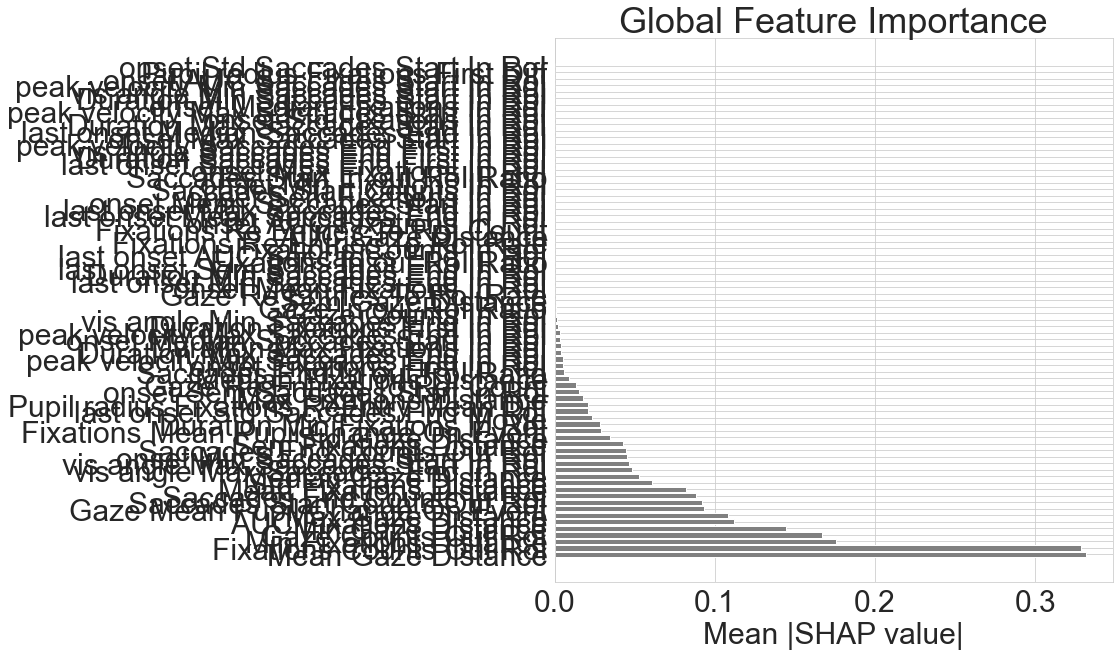

In [22]:
# After calculating SHAP values, aggregate them to measure the overall impact of each feature across all samples. You can then create a global feature importance plot, which ranks features by their importance (i.e., the sum of the absolute SHAP values for each feature across all samples). This plot will clearly show the Mean Gaze Distance as the most significant feature if its SHAP values are consistently higher than those of other features.

# Calculate the global feature importance
global_importance = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to store the global feature importance
global_importance_df = pd.DataFrame(global_importance, index=X_train_scaled.columns, columns=["Importance"])

# Sort the features by their importance
global_importance_df = global_importance_df.sort_values(by="Importance", ascending=False)

# Plot the global feature importance
plt.figure(figsize=(10, 10))
plt.barh(global_importance_df.index, global_importance_df["Importance"], color='gray')
plt.xlabel("Mean |SHAP value|")
plt.title("Global Feature Importance")
plt.show()


In [23]:
# # Perform statistical tests to compare the Mean Gaze Distance with other features
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import seaborn as sns
# 
# # Assuming `shap_values` as a DataFrame with features as columns
# mean_gaze_distance_shap = global_importance_df.loc['Mean Gaze Distance', 'Importance']
# other_features_shap = global_importance_df.drop('Mean Gaze Distance')['Importance']
# 
# # Wilcoxon Signed-Rank Test for each feature against Mean Gaze Distance
# p_values = {feature: stats.wilcoxon(mean_gaze_distance_shap, global_importance_df.loc[feature, 'Importance'])[1] for feature in other_features_shap.index}
# 
# # Adjust p-values for multiple comparisons, if necessary
# adjusted_p_values = {feature: val * len(p_values) for feature, val in p_values.items()}  # Example of Bonferroni correction
# 
# # Visualization
# sns.boxplot(data=shap_values[['Mean Gaze Distance'] + list(other_features_shap.columns)])
# plt.xticks(rotation=45)  
# plt.title("SHAP Values Distribution for Mean Gaze Distance vs Other Features")
# plt.tight_layout()
# plt.show()
# 
# # Print adjusted p-values
# for feature, p_val in adjusted_p_values.items():
#     print(f"{feature}: {p_val}")
#     

Study example use cases using shap force plots

In [24]:
# # Select a specific instance (e.g., the first instance)
# instance_index = 1
# shap_values_instance = shap_values[instance_index]
# X_test_instance = X_train_scaled.iloc[instance_index]
# 
# # Get the indices of the features with the top 5 absolute SHAP values
# top_indices = np.argsort(np.abs(shap_values_instance))[-5:]
# 
# # Create new SHAP values and feature arrays that only include these top 5 features
# shap_values_top = shap_values_instance[top_indices]
# X_test_top = X_test_instance.iloc[top_indices]
# 
# # Plot the SHAP force plot for the instance
# shap.force_plot(explainer.expected_value, shap_values_top, X_test_top, matplotlib=True)

In [25]:
# # Select a specific instance (e.g., the first instance)
# instance_index = 18
# 
# shap_values_instance = shap_values[instance_index]
# X_test_instance = X_train_scaled.iloc[instance_index]
# 
# # Get the indices of the features with the top 10 absolute SHAP values
# top_indices = np.argsort(np.abs(shap_values_instance))[:]
# 
# # Create new SHAP values and feature arrays that only include these top 10 features
# shap_values_top = shap_values_instance[top_indices]
# X_test_top = X_test_instance.iloc[top_indices]
# 
# # Plot the SHAP waterfall plot for the instance
# plt.figure(figsize=(10, 20))
# shap.plots.waterfall(shap.Explanation(values=shap_values_top, base_values=explainer.expected_value, data=X_test_top), max_display=7, show=False)
# 
# # Increase font size
# plt.rcParams.update({'font.size': 50})
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=25)
# # plt.tight_layout()
# 
# # Save the plot
# plt.savefig(os.path.join(config.classification_resource_dir, "shap_waterfall.svg"))
# 
# # print the true label of the instance
# print(f"True label: {y_train[instance_index]}")
# # print the pred label of the instance
# print(f"Pred label: {xgb.predict(X_test_instance.values.reshape(1, -1))[0]}")

In [26]:
# from xgboost import plot_tree
# 
# # plot single tree from the model big size
# fig = plt.figure(figsize=(20, 20))
# plot_tree(xgb, num_trees=0, rankdir='LR', ax=plt.gca())